In [1]:
#########################################################################################################
# create/read/regrid masks for HEMCO emissions

import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # to show the full numpy array
import pandas as pd
import xarray as xr
%matplotlib inline
import matplotlib.pyplot as plt
from gamap_colormap import WhGrYlRd 
import cartopy.crs as ccrs
import glob

In [4]:
#########################################################################################################
# your masks should match the spatial resolution of your GEOS-Chem model
os.chdir("/rds/projects/2018/maraisea-glu-01/RDS/GEOSChem/MASK")
sample_data = xr.open_dataset("sample_GEOS-Chem_output_AS_nested.nc4")
print(sample_data['lon'],sample_data['lat'],sep="\n##########################\n")

<xarray.DataArray 'lon' (lon: 145)>
array([ 60.   ,  60.625,  61.25 ,  61.875,  62.5  ,  63.125,  63.75 ,  64.375,
        65.   ,  65.625,  66.25 ,  66.875,  67.5  ,  68.125,  68.75 ,  69.375,
        70.   ,  70.625,  71.25 ,  71.875,  72.5  ,  73.125,  73.75 ,  74.375,
        75.   ,  75.625,  76.25 ,  76.875,  77.5  ,  78.125,  78.75 ,  79.375,
        80.   ,  80.625,  81.25 ,  81.875,  82.5  ,  83.125,  83.75 ,  84.375,
        85.   ,  85.625,  86.25 ,  86.875,  87.5  ,  88.125,  88.75 ,  89.375,
        90.   ,  90.625,  91.25 ,  91.875,  92.5  ,  93.125,  93.75 ,  94.375,
        95.   ,  95.625,  96.25 ,  96.875,  97.5  ,  98.125,  98.75 ,  99.375,
       100.   , 100.625, 101.25 , 101.875, 102.5  , 103.125, 103.75 , 104.375,
       105.   , 105.625, 106.25 , 106.875, 107.5  , 108.125, 108.75 , 109.375,
       110.   , 110.625, 111.25 , 111.875, 112.5  , 113.125, 113.75 , 114.375,
       115.   , 115.625, 116.25 , 116.875, 117.5  , 118.125, 118.75 , 119.375,
       120.   , 

In [5]:
#########################################################################################################
# prepare the masks over North China Plain (NCP)

# define the NCP domain (lon [ 107.5:122.5] lat [32:42])
# coordinates are for GEOS-Chem grid centres, not the domain boundaries

NCP_lon = np.arange(107.5,120.1,5/8) # (start,end+0.1,resolution)
NCP_lat = np.arange(32,43.1,1/2)
time = np.array(['2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
print(NCP_lon,NCP_lat,sep="\n##########################\n")

# double check if default GEOS-Chem grids contain all the NCP_lon and NCP_lat you've created
set1 = set(NCP_lon.flatten())
set2 = set(sample_data['lon'].values)
set3 = set(NCP_lat.flatten())
set4 = set(sample_data['lat'].values)
print(set1.issubset(set2),set3.issubset(set4))

[107.5   108.125 108.75  109.375 110.    110.625 111.25  111.875 112.5
 113.125 113.75  114.375 115.    115.625 116.25  116.875 117.5   118.125
 118.75  119.375 120.   ]
##########################
[32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43. ]
True True


In [6]:
#########################################################################################################
# NO emission mask
# a single emission factor guided by the model-surface comparison

NO_mask = np.full((1,len(NCP_lat),len(NCP_lon)), 1.4)

NO_mask = xr.DataArray(NO_mask, coords=[('time',time),('lat', NCP_lat),('lon', NCP_lon)])
NO_mask.name = "MASK"
NO_mask['lon'].attrs = {'long_name':'longitude','units':'degrees_east','axis':'X'}
NO_mask['lat'].attrs = {'long_name':'Latitude','units':'degrees_north','axis':'Y'}
NO_mask.attrs = {'long_name':'NO emission mask for North China Plain','units':'unitless'}
NO_mask.to_netcdf("NCP_mask_NO_Gongda.nc")

In [7]:
#########################################################################################################
# SO2 factor 

# read emission factors for SO2
SO2_emission_factors = pd.read_csv("SO2_emission_factors.csv")
print(SO2_emission_factors)

# locate the grids on map
print(NCP_lat[8],NCP_lon[6])
print(NCP_lat[8],NCP_lon[9])
print(NCP_lat[11],NCP_lon[8])
print(NCP_lat[12],NCP_lon[8])
print(NCP_lat[12],NCP_lon[10])
print(NCP_lat[13],NCP_lon[8])
print(NCP_lat[15],NCP_lon[8])

    lat      lon  factor
0  36.0  111.250    6.82
1  36.0  113.125    3.31
2  37.5  112.500    3.88
3  38.0  112.500    2.19
4  38.0  113.750    2.06
5  38.5  112.500    3.74
6  39.5  112.500    3.14
36.0 111.25
36.0 113.125
37.5 112.5
38.0 112.5
38.0 113.75
38.5 112.5
39.5 112.5


In [8]:
# set base = 1, then apply factors only for some target grids
SO2_mask = np.ones((1,len(NCP_lat),len(NCP_lon)),dtype = float)

# assign emission factors [time,lat,lon]
SO2_mask[0,8,6] = 6.8
SO2_mask[0,8,9] = 3.3 
SO2_mask[0,11,8] = 3.9 
SO2_mask[0,12,8] = 2.2 
SO2_mask[0,12,10] = 2.1 
SO2_mask[0,13,8] = 3.8 
SO2_mask[0,15,8] = 3.1 

# output the mask
SO2_mask = xr.DataArray(SO2_mask, coords=[('time',time),('lat', NCP_lat),('lon', NCP_lon)])
SO2_mask.name = "MASK"
SO2_mask['lon'].attrs = {'long_name':'Longitude','units':'degrees_east','axis':'X'}
SO2_mask['lat'].attrs = {'long_name':'Latitude','units':'degrees_north','axis':'Y'}
SO2_mask.attrs = {'long_name':'SO2 emission mask for North China Plain','units':'unitless'}
SO2_mask.to_netcdf("NCP_mask_SO2_Gongda.nc")

In [6]:
#########################################################################################################
# CO emission factor
# a single emission factor guided by the model-surface comparison

NCP_mask_CO = np.full((1,len(NCP_lat),len(NCP_lon)), 2.4)

NCP_mask_CO = xr.DataArray(NCP_mask_CO, coords=[('time',time),('lat', NCP_lat),('lon', NCP_lon)])
NCP_mask_CO.name = "MASK"
NCP_mask_CO['lon'].attrs = {'long_name':'Longitude','units':'degrees_east','axis':'X'}
NCP_mask_CO['lat'].attrs = {'long_name':'Latitude','units':'degrees_north','axis':'Y'}
NCP_mask_CO.attrs = {'long_name':'CO emission mask for North China Plain','units':'unitless'}
NCP_mask_CO.to_netcdf("NCP_mask_CO_Gongda.nc")

In [8]:
#########################################################################################################
# VOCs factor
# here just try some values since there is no surface measurement

VOCs_mask_1 = np.full((1,len(NCP_lat),len(NCP_lon)),1.5)
VOCs_mask_1 = xr.DataArray(VOCs_mask_1, coords=[('time',time),('lat', NCP_lat),('lon', NCP_lon)])
VOCs_mask_1.name = "MASK"
VOCs_mask_1['lon'].attrs = {'long_name':'Longitude','units':'degrees_east','axis':'X'}
VOCs_mask_1['lat'].attrs = {'long_name':'Latitude','units':'degrees_north','axis':'Y'}
VOCs_mask_1.attrs = {'long_name':'VOCs emission mask for North China Plain','units':'unitless'}
VOCs_mask_1.to_netcdf("NCP_mask_VOCs_1_Gongda.nc")

VOCs_mask_2 = np.full((1,len(NCP_lat),len(NCP_lon)),2)
VOCs_mask_2 = xr.DataArray(VOCs_mask_2, coords=[('time',time),('lat', NCP_lat),('lon', NCP_lon)])
VOCs_mask_2.name = "MASK"
VOCs_mask_2['lon'].attrs = {'long_name':'Longitude','units':'degrees_east','axis':'X'}
VOCs_mask_2['lat'].attrs = {'long_name':'Latitude','units':'degrees_north','axis':'Y'}
VOCs_mask_2.attrs = {'long_name':'VOCs emission mask for North China Plain','units':'unitless'}
VOCs_mask_2.to_netcdf("NCP_mask_VOCs_2_Gongda.nc")

In [9]:
#########################################################################################################
# quick visualisation of your masks
NO_mask  = xr.open_dataset("NCP_mask_NO_Gongda.nc")
SO2_mask = xr.open_dataset("NCP_mask_SO2_Gongda.nc")
CO_mask  = xr.open_dataset("NCP_mask_CO_Gongda.nc")
VOCs_mask_1 = xr.open_dataset("NCP_mask_VOCs_1_Gongda.nc")
VOCs_mask_2 = xr.open_dataset("NCP_mask_VOCs_2_Gongda.nc")

NO_mask  = NO_mask['MASK']
SO2_mask = SO2_mask['MASK']
CO_mask = CO_mask['MASK']
VOCs_mask_1 = VOCs_mask_1['MASK']
VOCs_mask_2 = VOCs_mask_2['MASK']

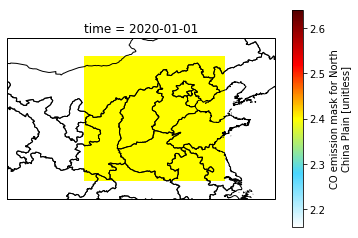

In [24]:
# a quick plot

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
os.chdir('/rds/projects/2018/maraisea-glu-01/Study/Research_Data/BTH/domain/CHN_ADM')
China_shape = r'CHN_ADM1.shp'
china_map = ShapelyFeature(Reader(China_shape).geometries(),
                               ccrs.PlateCarree(), edgecolor='black',facecolor='none')

t= plt.axes(projection=ccrs.PlateCarree())
t.add_feature(china_map)
t.set_extent([100, 125, 30, 45], crs=ccrs.PlateCarree()) # [lon,lon,lat,lat]

CO_mask.plot(ax=t,cmap=WhGrYlRd)